In [1]:
import keras.optimizers
import numpy as np, os, pathlib, matplotlib.pyplot as plt, sys, seaborn as sns
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Reshape, Lambda, Concatenate
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Rescaling, Reshape, Resizing, RandomZoom, RandomRotation, RandomFlip

import tensorflow as tf
from keras.metrics.metrics import binary_crossentropy
from keras.layers import LeakyReLU
from keras import backend as bk
# from tensorflow.keras.utils import to_categorical
import parameters as p

In [2]:
# PARAMETERS
batch_size = 240
latent_dim = 512  # to be easier generate and visualize result
dropout_r = 0.1
lr_0 = 0.0001
epoch = 10

img_height = 224
img_width = 224
ims = 224

Adam = keras.optimizers.Adam

In [3]:
name = f'pets_cvae_dim{latent_dim}_epochs{epoch}_ims{ims}'

data_dir = p.dataset_folder
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print('Number of images:', image_count)

Number of images: 4800


In [4]:
if batch_size < image_count:
    batch_size = int(image_count * 0.05)
    # print(batch_size)
else:
    batch_size = image_count // 2

print('BATCH SIZE:', batch_size)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)


BATCH SIZE: 240


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    batch_size=batch_size,
    image_size=(ims, ims),
    labels='inferred',
    label_mode='categorical',
    color_mode="rgb"
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    batch_size=batch_size,
    image_size=(ims, ims),
    labels='inferred',
    label_mode='categorical',
    color_mode="rgb"
)

ishape = (ims, ims, 3)
class_names = train_ds.class_names  # os.listdir(os.path.join(data_dir))
num_classes = len(class_names)
print('num_classes:', num_classes, '-', class_names)


full_imgs = lambda ds: np.concatenate([x for x, y in ds])
full_lbls = lambda ds: np.concatenate([y for x, y in ds])

train_img = full_imgs(train_ds)
train_img = train_img.astype('float32') / 255.
train_lbl = full_lbls(train_ds)
# train_lbl_cat = tf.keras.utils.to_categorical(train_lbl).astype(np.float32)

valid_img = full_imgs(valid_ds)
valid_img = valid_img.astype('float32') / 255.
valid_lbl = full_lbls(valid_ds)
print('\n\nshape train_img, train_lbl:', np.shape(train_img), np.shape(train_lbl), '\n')

Found 4800 files belonging to 2 classes.
Using 3840 files for training.
Found 4800 files belonging to 2 classes.
Using 960 files for validation.
num_classes: 2 - ['cats', 'dogs']


shape train_img, train_lbl: (3840, 224, 224, 3) (3840, 2) 



In [6]:
def create_cvae():
    models = {}

    def apply_bn_and_dropout(x):
        return Dropout(dropout_r)(BatchNormalization()(x))

    # Encoder
    inp_img = Input(shape=ishape)  # batch_shape=(batch_size, ims, ims, 1)
    flat = Flatten()(inp_img)
    inp_lbls = Input(shape=(num_classes,), dtype='float32')

    x = concatenate([flat, inp_lbls])
    x = Dense(2048, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = Dense(1024, activation='relu')(x)
    # x = apply_bn_and_dropout(x)

    # predict logarithm of variation instead of standard deviation
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # sampling from Q with reparametrisation
    def sampling(args):
        z_means, z_log_vars = args
        epsilon = bk.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_means + bk.exp(z_log_vars / 2) * epsilon

    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    l_z = concatenate([l, inp_lbls])

    encoder = Model([inp_img, inp_lbls], l_z, name='my_encoder')
    z_meaner = Model([inp_img, inp_lbls], z_mean, name='Enc_z_mean')
    models["encoder"] = encoder
    models["z_meaner"] = z_meaner
    models["z_lvarer"] = Model([inp_img, inp_lbls], z_log_var, name='Enc_z_log_var')

    # Decoder
    z = Input(shape=(latent_dim + num_classes,))
    x = Dense(1024)(z)
    x = LeakyReLU()(x)
    x = apply_bn_and_dropout(x)
    x = Dense(2048)(z)
    x = LeakyReLU()(x)
    # x = apply_bn_and_dropout(x)
    x = Dense(ims * ims * 3, activation='sigmoid')(x)
    decoded = Reshape(ishape)(x)

    decoder = Model(z, decoded, name='my_decoder')  # [z, inp_lbls_d]

    models["decoder"] = decoder

    cvae_out = decoder(encoder([inp_img, inp_lbls]))

    my_cvae = Model([inp_img, inp_lbls], cvae_out, name='my_cvae')
    models['cvae'] = my_cvae

    out_style = decoder(concatenate([z_meaner([inp_img, inp_lbls]), inp_lbls]))
    models["style_t"] = Model([inp_img, inp_lbls], out_style, name="style_transfer")

    def vae_loss(x, decoded):
        x = bk.reshape(x, shape=(batch_size, ims * ims * 3))
        decoded = bk.reshape(decoded, shape=(batch_size, ims * ims * 3))
        xent_loss = ims * ims * 3 * binary_crossentropy(x, decoded)
        kl_loss = -0.5 * bk.sum(1 + z_log_var - bk.square(z_mean) - bk.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/ims/ims/3

    return models, vae_loss


In [7]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [8]:
cvae_models, cvae_losses = create_cvae()
cvae = cvae_models["cvae"]

cvae.compile(optimizer='adam', loss=cvae_losses, experimental_run_tf_function=False)  # cvae_losses

# Plot images / imagss
# imags_size = ims

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def plot_imagss(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n_f = min([x.shape[0] for x in args])
    figure = np.zeros((ims * len(args), ims * n_f, 3))

    for i in range(n_f):
        for j in range(len(args)):
            figure[j * ims: (j + 1) * ims,
            i * ims: (i + 1) * ims, :] = args[j][i].squeeze()

    if invert_colors:
        figure = 1 - figure

    plt.figure(figsize=(2 * n_f, 2 * len(args)))
    plt.imshow(figure)  # cmap='Greys_r'
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
n = 15  # Img with 15x15 imagss

from scipy.stats import norm

# Since we are sampling from N(0, I),
# we take the grid of nodes in which we generate numbers from the inverse distribution function
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [12]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

In [13]:
figs = [[] for x in range(num_classes)]
latent_distrs = [[] for x in range(num_classes)]
epochs = []

# Saves epoches
save_epochs = set(list((np.arange(0, 59) ** 1.701).astype(int)) + list(range(10)))

# We'll be tracking on these numbers
imgs = valid_img[:batch_size]
imgs_lbls = valid_lbl[:batch_size]
n_compare = 10

# Models
generator = cvae_models["decoder"]
encoder_mean = cvae_models["z_meaner"]

In [58]:
# The function that we will run after each epoch
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output()

        # Comparison of real and decoded numbers
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_imagss(imgs[:n_compare], decoded[:n_compare])

        draw_lbl = np.random.randint(0, num_classes)
        print(draw_lbl)
        for lbl in range(num_classes):
            figs[lbl].append(draw_manifold(generator, lbl, show=lbl == draw_lbl))
            idxs = valid_img == lbl
            z_predicted = encoder_mean.predict([valid_img[idxs], imgs_lbls[idxs]], batch_size)
            latent_distrs[lbl].append(z_predicted)
            if lbl == draw_lbl:
                draw_z_distr(z_predicted, lbl)
        epochs.append(epoch)

In [59]:
lambda_pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb = TensorBoard(log_dir=f'logs/{name}')

In [84]:
def style_transfer(model, X, lbl_in, lbl_out):
    rows = X.shape[0]
    if isinstance(lbl_in, int):
        lbl_f = lbl_in
        lbl_in = np.zeros((rows, 2))
        lbl_in[:, lbl_f] = 1
    if isinstance(lbl_out, int):
        lbl_f = lbl_out
        lbl_out = np.zeros((rows, 2))
        lbl_out[:, lbl_f] = 1
    return model.predict([X, lbl_in, lbl_out])

def draw_z_distr(z_predicted, lbl):
    input_lbl = np.zeros((1, 10))
    input_lbl[0, lbl] = 1
    im = plt.scatter(z_predicted[:, 0], z_predicted[:, 1])
    im.axes.set_xlim(-5, 5)
    im.axes.set_ylim(-5, 5)
    plt.show()

In [17]:
cvae.fit(
    x=[train_img, train_lbl],
    y=train_img,
    batch_size=batch_size,
    shuffle=True,
    epochs=epoch,
    validation_data=([valid_img, valid_lbl], valid_img),
    callbacks=[tb],
    verbose=1)

Train on 3840 samples, validate on 960 samples
Epoch 1/10
3840/3840 [==============================] - ETA: 0s - loss: 0.3338

C:\Users\Ksenia\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3840/3840 [==============================] - 84s 22ms/sample - loss: 0.3338 - val_loss: 0.5690
Epoch 2/10
3840/3840 [==============================] - 77s 20ms/sample - loss: 0.3139 - val_loss: 0.3947
Epoch 3/10
3840/3840 [==============================] - 77s 20ms/sample - loss: 0.3076 - val_loss: 0.3370
Epoch 4/10
3840/3840 [==============================] - 77s 20ms/sample - loss: 0.3037 - val_loss: 0.3138
Epoch 5/10
3840/3840 [==============================] - 78s 20ms/sample - loss: 0.3008 - val_loss: 0.3030
Epoch 6/10
3840/3840 [==============================] - 78s 20ms/sample - loss: 0.2985 - val_loss: 0.3008
Epoch 7/10
3840/3840 [==============================] - 79s 21ms/sample - loss: 0.2977 - val_loss: 0.2988
Epoch 8/10
3840/3840 [==============================] - 77s 20ms/sample - loss: 0.2964 - val_loss: 0.2987
Epoch 9/10
3840/3840 [==============================] - 78s 20ms/sample - loss: 0.2953 - val_loss: 0.2982
Epoch 10/10
3840/3840 [==============================] - 

0
1


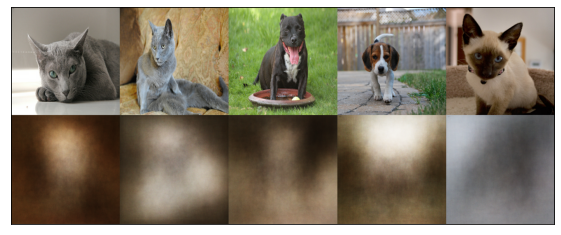

In [61]:
n = 5
# lbls = [2, 3, 5, 6, 7]
# for lbl in lbls:
lbl = 0
generated = []

for i in range(num_classes):
    print(i)
    prot = train_img[train_lbl.T[0] == i][:n]
    generated.append(style_transfer(cvae_models["style_t"], prot, lbl, i))

prot = train_img[train_lbl.T[0] == lbl][:n]
generated[lbl] = prot
plot_imagss(*generated, invert_colors=False)

<class 'numpy.ndarray'>
(240, 224, 224, 3)


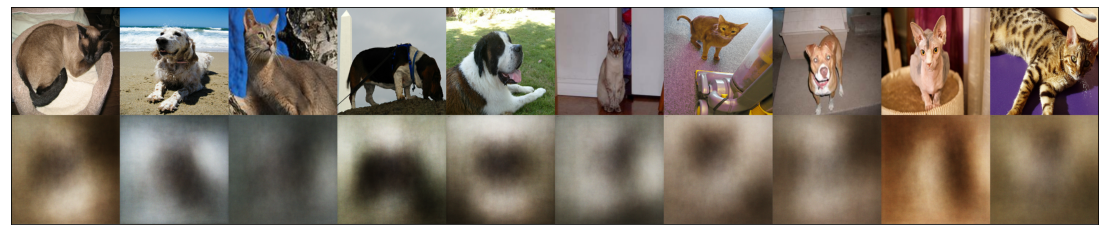

In [20]:
# Comparison of real and decoded numbers
print(type(imgs))
print(imgs.shape)
decoded = cvae.predict([imgs, imgs_lbls], batch_size=batch_size)
plot_imagss(imgs[:n_compare], decoded[:n_compare])


In [81]:
def draw_manifold(generator, lbl, show=True):
    figure = np.zeros((ims * n, ims * n, 3))
    input_lbl = np.zeros((1, 10))
    input_lbl[0, lbl] = 1
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim+num_classes))
            z_sample[:, :2] = np.array([[xi, yi]])
            # print(z_sample.shape)
            
            # print(input_lbl.shape)
            x_decoded = generator.predict([z_sample, input_lbl])
            imags = x_decoded[0].squeeze()
            # print('imags shape: ', imags.shape, '; figure shape: ', figure.shape)
            # print('i', i, ', j+1', j+1)
            if j<n and i<n:
                figure[i * ims: (i + 1) * ims, j * ims: (j + 1) * ims, :] = imags
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap='Greys_r')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure



imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 1
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 2
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 3
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 4
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 5
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 6
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 7
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 8
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 9
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 10
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 11
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 12
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 0 , j+1 13
imags shape:  (224, 224, 3) ; figure shape:  (1

imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 7 , j+1 9
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 7 , j+1 10
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 7 , j+1 11
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 7 , j+1 12
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 7 , j+1 13
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 7 , j+1 14
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 7 , j+1 15
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 8 , j+1 1
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 8 , j+1 2
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 8 , j+1 3
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 8 , j+1 4
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 8 , j+1 5
imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 8 , j+1 6
imags shape:  (224, 224, 3) ; figure shape:  

imags shape:  (224, 224, 3) ; figure shape:  (1120, 1120, 3)
i 14 , j+1 15


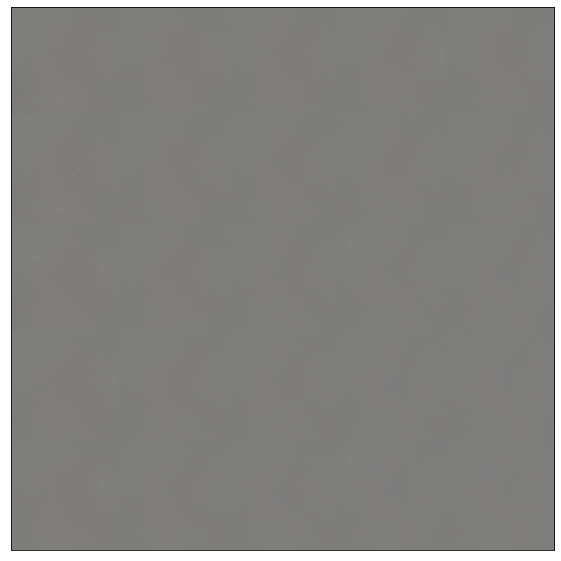

In [82]:
# Manifold drawing
figure = draw_manifold(generator, lbl=1, show=True)